# Value at Risk Exploration

## To what extent can Value at Risk serve as a reliable metric to gauge financial risk?
Many financial institutions have experienced huge losses over the past decade, due to fraud, bad management or poor advice. Regardless of the contributing factors they all strive to avoid repeating the same mistakes again. Therefore, institutions employ mathematical models to gauge financial risk.

Value at Risk (VaR) is an extremely popular mathematical model among corporate financial risk managers and an industry standard, to quantify the risk of financial assets. VaR is based on the probability of a possible loss over a specific time horizon in which this loss is expected to occur caused by adverse market movements (Simons, 2001).
VaR is extremely appealing, because it breaks risk down into a single number. Hence, it is also comprehensible by people without an extensive background in risk management, such as executives or customers.

However, as popularity of VaR increased criticism arose, too. The objective of this paper is to evaluate these critiques in order to determine whether Value at Risk can be used as a reliable metric to measure risk. There are countless different approaches to calculate VaR. In order to limit the scope of the paper the following methods shall be assessed: normal, hybrid and historical Value at Risk.
    
This paper will be based primarily on existing research. I’ll be using journals (from different databases) and technical literature. Existing approaches to calculate VaR and different perspectives will be explored. In order to test different theories I will apply these concepts and measure how well these three metrics perform against historical return information from a small sample of S&P 500 Stocks.

**Plan**

I'll begin the exploration by loading and analyzing a single dataset and write the necessary functions. I'll then work on writing loops to evaluate multiple models at the same time.
1. Import CSV File into Pandas Dataset
2. Initial Data Exploration
3. Preprocessing - calculating the Rate of Return
4. Normal Value at Risk
    * Calculate nVaR
    * Analyze the number, frequency and magnitude of exceedances
    * Compare and Contrast different nVaR confidence levels (99% & 95%)
5. Modified Value at Risk
    * Calculate mVaR
    * Analyze the number, frequency and magnitude of exceedances
    * Compare and Contrast different nVaR confidence levels (99% & 95%) 
6. Historical Value at Risk
    * Calculate hVaR
    * Analyze the number, frequency and magnitude of exceedances
    * Compare and Contrast different nVaR confidence levels (99%)  

## Data Loading
I'll begin my exploration with the analysis of the Amazon (AMZN) stock. I downloaded data on June 4th 2016 from Yahoo finance for the period from May 16th 1997 to today and saved it to an AMZN.csv file.

In [39]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy
import math
mpl.rcParams['lines.linewidth'] = 1
%matplotlib inline

In [40]:
def rate_of_return(dataframe):
    
    r_of_return = ((dataframe['Close']-dataframe['Close'].shift(1))/dataframe['Close'].shift(1))
    dataframe['Rate of Return'] = pd.Series(r_of_return, index=dataframe.index)

def actual_return(dataframe):
    dataframe['Actual Return'] = pd.Series(dataframe['Close']*(dataframe['Rate of Return']), index=dataframe.index)

# Added Rate of Return and removed the first row
rate_of_return(amzn_data)
actual_return(amzn_data)

# For loading calculations implemented the following function
def data_loading(file):
    data = pd.read_csv(file, index_col=0, parse_dates=[0])
    data.sort_index(inplace=True)
    rate_of_return(data)
    actual_return(data)
    return data

## Normal Value at Risk

In [58]:
nvar_data = data_loading("data/amzn.csv")

In [59]:
def data_statistics(dataset):
    return {'mean': np.mean(dataset['Rate of Return']), 
            'std': np.std(dataset['Rate of Return'])}

# Calculating the mean of the Amazon Dataset
amzn_mean = data_statistics(nvar_data)['mean']

# Calculating the Standard Deviation
amzn_std = data_statistics(nvar_data)['std']

# Calculate number of examples
print "The dataset includes {} trading days".format(nvar_data.shape[0])

# Z Score for 95% confidence level
z_95 = scipy.stats.norm.ppf(.05)

# Z score for 99% confidence level
z_99 = scipy.stats.norm.ppf(.01)

The dataset includes 4794 trading days


In [60]:
# Calculating 1 Day, 95% and 99% confidence level normal Value at Risk
def n_var(dataframe):
    
    # Calculating a 95% 1 Day nVaR
    n_var_95 = (z_95*amzn_std)*dataframe['Close'].shift(1)
    dataframe['95% nVaR'] = pd.Series(n_var_95, index=dataframe.index)
    
    # Calculating a 99% 1 Day nVaR
    n_var_99 = (z_99*amzn_std)*dataframe['Close'].shift(1)
    dataframe['99% nVaR'] = pd.Series(n_var_99, index=dataframe.index)

n_var(nvar_data)

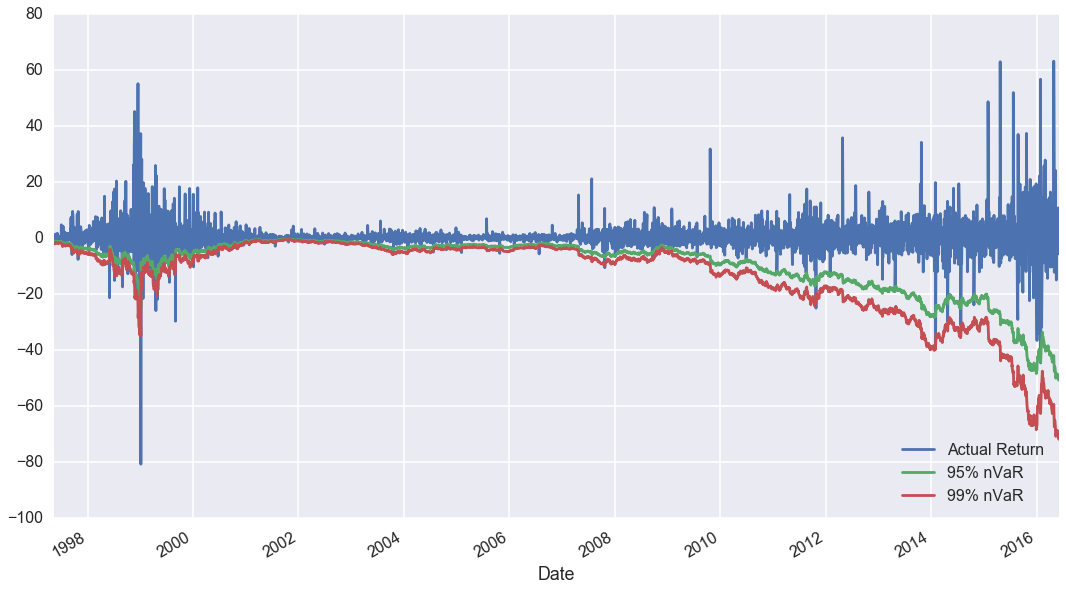

In [61]:
nvar_data[['Actual Return', '95% nVaR', '99% nVaR']].plot(figsize=(18, 10))

### Analyzing exceedances

In [62]:
def exceedance_occurred(dataframe, var_95, var_99):
    dataframe['Exceedance 95%'] = dataframe['Actual Return'].divide(dataframe[var_95])
    dataframe['Exceedance 99%'] = dataframe['Actual Return'].divide(dataframe[var_99])
    dataframe['Exceedance 95%'].astype(float)

exceedance_occurred(nvar_data, '95% nVaR', '99% nVaR')

In [63]:
def calc_exceedance_stats(column):
    mean_e = round(np.mean(column.where(column>1)),4)
    std_e = round(np.std(column.where(column>1)),4)
    count = round((column.where(column>1).dropna().shape[0]),0)
    print "The mean exceedance is {} with a standard devition of {}. In the period {} exceedances occurred".format(mean_e, std_e, count)

print '95% Confidence Level:'
calc_exceedance_stats(nvar_data['Exceedance 95%'])
print '\n99% Confidence Level:'
calc_exceedance_stats(nvar_data['Exceedance 99%'])

95% Confidence Level:
The mean exceedance is 1.4206 with a standard devition of 0.465. In the period 124.0 exceedances occurred

99% Confidence Level:
The mean exceedance is 1.3211 with a standard devition of 0.3688. In the period 44.0 exceedances occurred


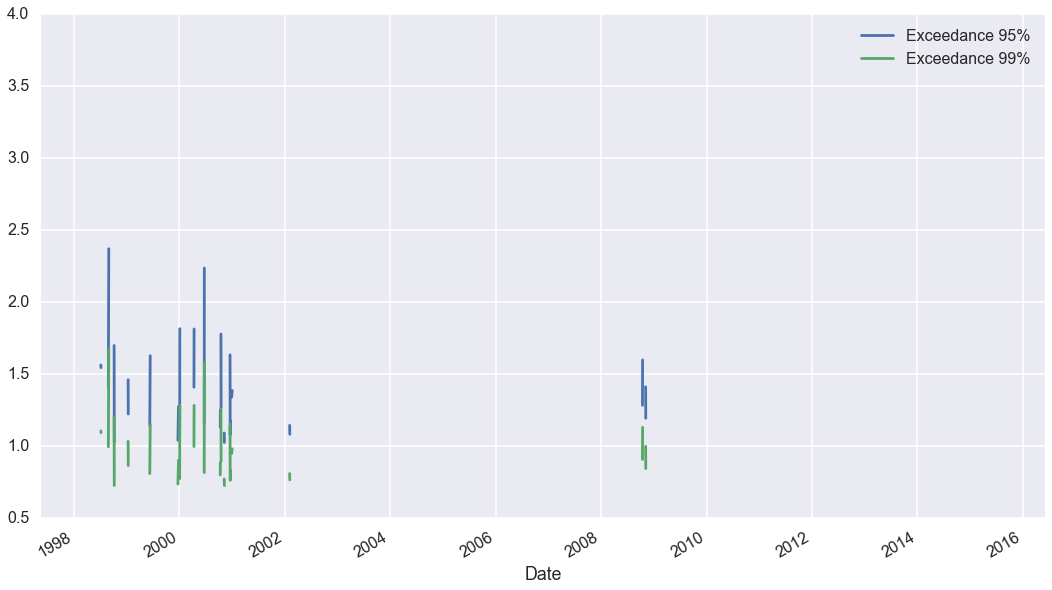

In [64]:
nvar_data[['Exceedance 95%','Exceedance 99%']].where(nvar_data['Exceedance 95%']>1).plot(figsize=(18, 10))

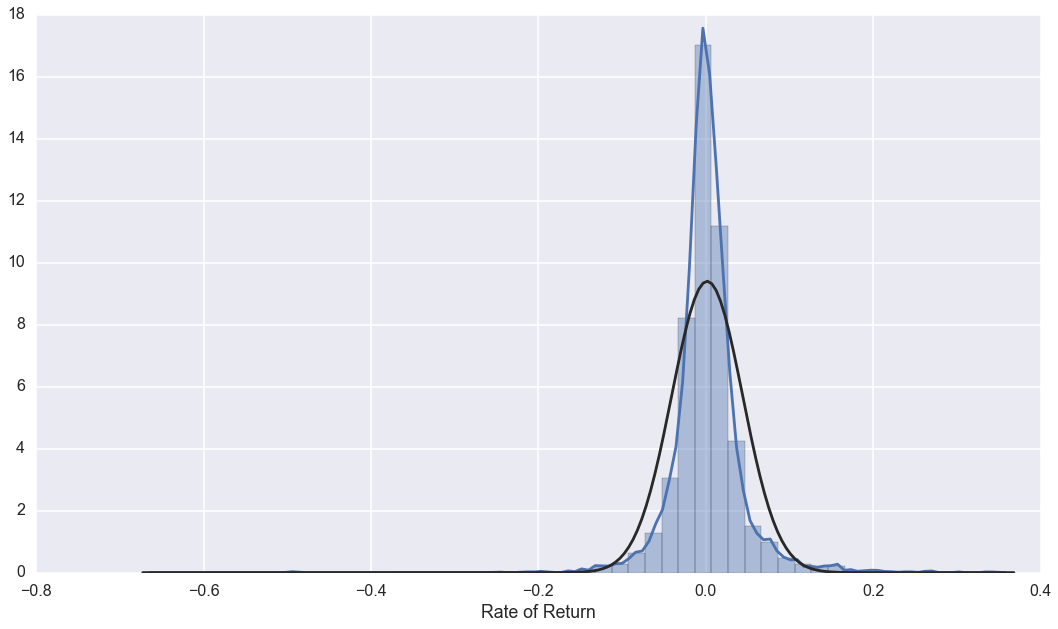

In [67]:
sns.set_context("poster")
plt.figure(figsize=(18, 10))
sns.distplot(nvar_data['Rate of Return'][1:], fit=scipy.stats.norm)

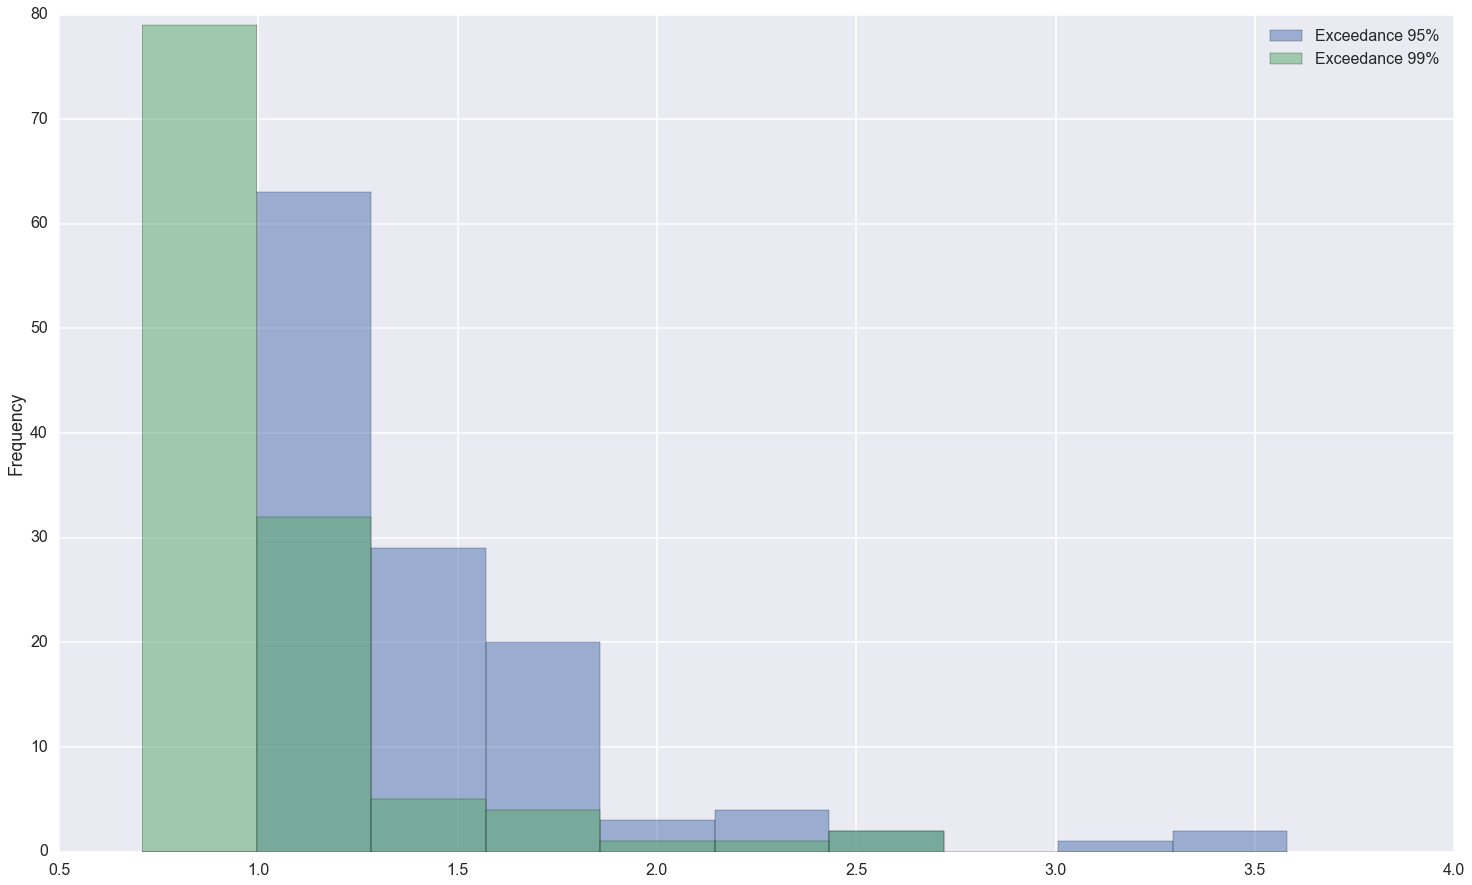

In [68]:
nvar_data[['Exceedance 95%','Exceedance 99%']].where(nvar_data['Exceedance 95%']>1).dropna().plot.hist(alpha=0.5, figsize=(25, 15))

## Modified Value at Risk
Since VaR relies on a distribution that should fit our data, we need to find a distribution that solves our needs to better fit the tails. Student's t distribution is a better choice, since one of its parameters is the fourth central moment also known as kurtosis, which defines the "fatness" of the tails.
The summarize, the distribution is influenced by kurtosis, scale factor and the mean.

In [69]:
mvar_data = data_loading("data/noc.csv")

In [70]:
mvar_mean = data_statistics(mvar_data)['mean']
mvar_std = data_statistics(mvar_data)['std']

# Calculating kurtosis
kurtosis = np.sum(((mvar_data['Close']-mvar_mean)/mvar_std).pow(4))
scale_factor = mvar_std/(math.sqrt(kurtosis/(kurtosis-2)))

In [71]:
dist = getattr(scipy.stats, 't')
param = dist.fit(mvar_data['Rate of Return'][1:])
degrees_freedom = param[0]

t_95 = -2.920
t_99 = -6.965

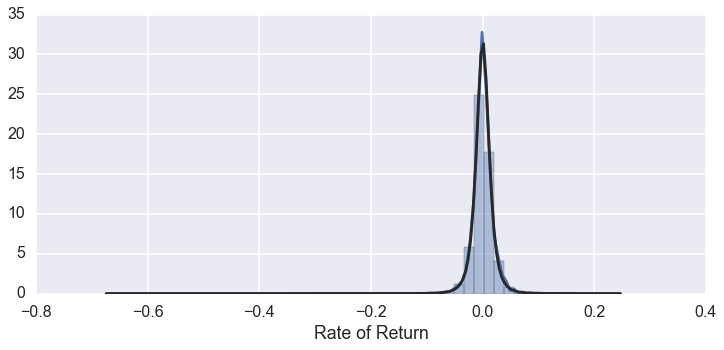

In [72]:
sns.set_context("poster")
plt.figure(figsize=(12, 5))
sns.distplot(mvar_data['Rate of Return'][1:], fit=scipy.stats.t)

In [73]:
mvar_data['95% mVaR'] = mvar_data['Close'].shift(1)*(scale_factor*t_95+mvar_mean)
mvar_data['99% mVaR'] = mvar_data['Close'].shift(1)*(scale_factor*t_99+mvar_mean)

In [74]:
mvar_data

,Open,High,Low,Close,Volume,Adj Close,Rate of Return,Actual Return,95% mVaR,99% mVaR
Date,,,,,,,,,,
1981-12-31,52.374976,52.499959,52.249997,52.374976,33800,2.886556,NaN,NaN,NaN,NaN
1982-01-04,52.249997,52.374976,52.125017,52.125017,65000,2.872780,-0.004772,-0.248766,-3.004235,-7.194219
1982-01-05,52.249997,52.374976,52.125017,52.125017,318000,2.872780,0.000000,0.000000,-2.989897,-7.159885
1982-01-06,50.875012,51.874989,49.749986,50.375022,369200,2.776332,-0.033573,-1.691242,-2.989897,-7.159885
1982-01-07,49.125016,49.500024,48.624963,49.500024,151400,2.728108,-0.017370,-0.859800,-2.889517,-6.919506
1982-01-08,50.500001,51.499981,49.500024,51.250020,305400,2.824556,0.035353,1.811864,-2.839327,-6.799316
1982-01-11,48.499980,50.999991,45.874990,45.874990,687300,2.528320,-0.104879,-4.811304,-2.939707,-7.039695
1982-01-12,45.499982,45.999969,44.875012,44.875012,238400,2.473208,-0.021798,-0.978181,-2.631395,-6.301382
1982-01-13,43.625007,44.500005,42.750009,42.750009,478100,2.356092,-0.047354,-2.024376,-2.574036,-6.164025


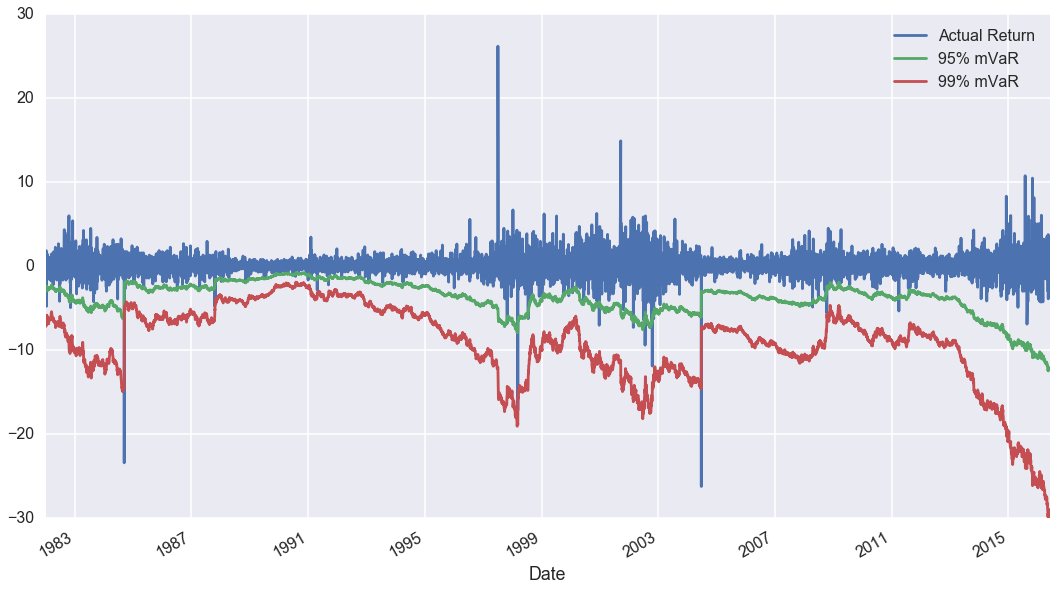

In [75]:
mvar_data[['Actual Return', '95% mVaR', '99% mVaR']].plot(figsize=(18, 10))

In [76]:
exceedance_occurred(mvar_data, '95% mVaR', '99% mVaR')

In [77]:
print '95% Confidence Level:'
calc_exceedance_stats(mvar_data['Exceedance 95%'])
print '\n99% Confidence Level:'
calc_exceedance_stats(mvar_data['Exceedance 99%'])

95% Confidence Level:
The mean exceedance is 1.4899 with a standard devition of 0.7074. In the period 37.0 exceedances occurred

99% Confidence Level:
The mean exceedance is 1.7208 with a standard devition of 0.0992. In the period 2.0 exceedances occurred


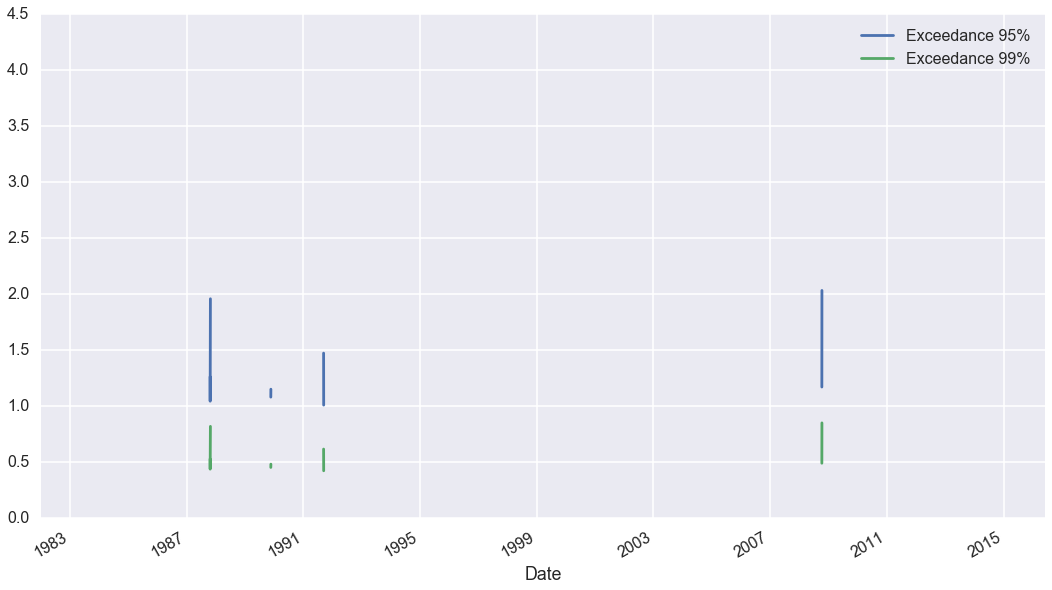

In [78]:
mvar_data[['Exceedance 95%','Exceedance 99%']].where(mvar_data['Exceedance 95%']>1).plot(figsize=(18, 10))

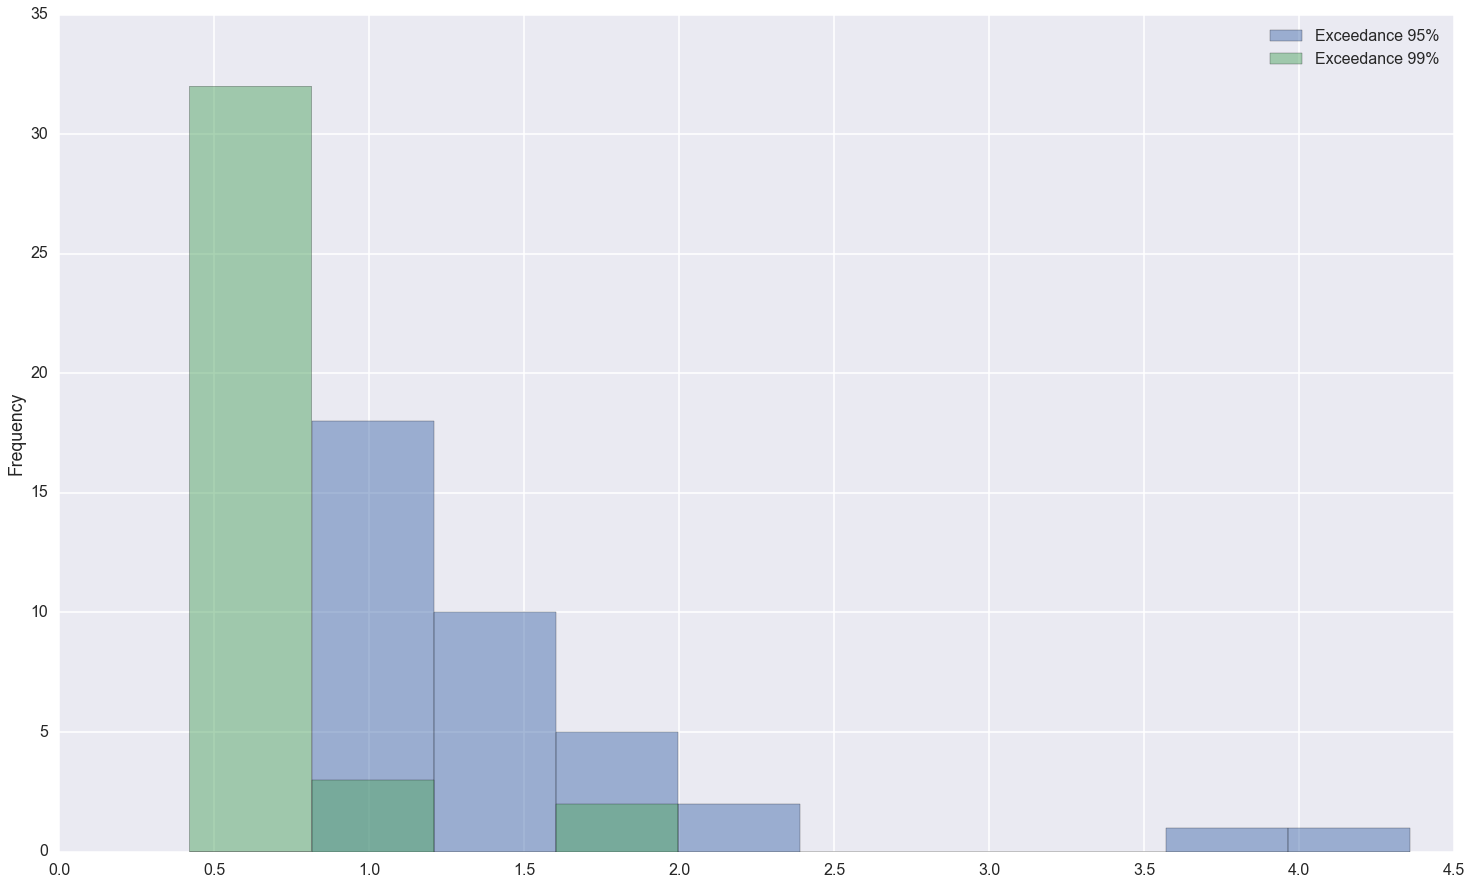

In [79]:
mvar_data[['Exceedance 95%','Exceedance 99%']].where(mvar_data['Exceedance 95%']>1).dropna().plot.hist(alpha=0.5, figsize=(25, 15))